# Modelo diferenciador de imágenes objeto vs. piel

---

## Origen de los datos

---

* Las imágenes de piel para la realización de este modelo han sido obtenidas mediante la unión de diferentes datasets utilizados en el proyecto que contienen imágenes de piel en diferentes estados:

  * Imágenes del dataset piel sana:  https://www.kaggle.com/datasets/thanatw/isic2019-modded

  * Imágenes del dataset piel con cáncer, benigna / maligna : https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

* Las imágenes de objetos  que no son piel y otra serie de imágenes variadas han sido obtenidas del siguiente enlace: https://www.kaggle.com/datasets/greg115/various-tagged-images

## Instalación de recursos e importación de librerías

---

* Realizamos todas las instalaciones necesarias para la elaboración de nuestros modelos.

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torchvision


  Using cached torchvision-0.17.1-cp39-cp39-win_amd64.whl.metadata (6.6 kB)
  Using cached torch-2.2.1-cp39-cp39-win_amd64.whl.metadata (26 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torchvision-0.17.1-cp39-cp39-win_amd64.whl (1.2 MB)
Using cached torch-2.2.1-cp39-cp39-win_amd64.whl (198.5 MB)
Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
Using cached Jinja2-3.1.3-py3-none-any.whl (133 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


* Importacion de librerías

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import zipfile
import scipy
import os
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet121

from keras.utils import to_categorical
from keras.applications import VGG19
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report

from PIL import Image

%matplotlib inline

## Extracción de los datos

---

* Realizamos la conexión con Drive donde se encuentran las imágenes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

* Procedemos a la extraccíón de los datos:

  *  Especificamos la ruta del origen de los datos y la ruta del destino donde los datos son extraidos y descomprimidos.
  * Listamos las carpetas extraidas y las imprimimos.
  * Creamos la variable `train_dir` que contiene las carpetas con las imágenes correspondientes a las dos clases principales con las que vamos a trabajar nuestros modelos: `objeto` y `piel`.

In [8]:
# Ruta del archivo ZIP en Google Drive
ruta_archivo_zip = 'C:/Users/admin2/Desktop/dermascan_colabs/zips/objeto_o_piel.zip'

# Ruta donde deseas extraer los archivos
ruta_destino = 'C:/Users/admin2/Desktop/dermascan_colabs/unzips/'

# Descomprime el contenido del ZIP
with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(ruta_destino)

# Lista los archivos extraídos
archivos_extraidos = os.listdir(ruta_destino)
print(f'Archivos extraídos: {archivos_extraidos}')

# Ruta de la carpeta que contiene las imágenes
train_dir = os.path.join(ruta_destino, 'objeto_o_piel')

# Verifica la existencia de la carpeta antes de listar los archivos
if os.path.exists(train_dir):
    archivos_en_carpeta = os.listdir(train_dir)
    print(f'Archivos en la carpeta: {archivos_en_carpeta}')
else:
    print(f'La carpeta {train_dir} no existe.')

# Lista de nombres de archivos en la carpeta
object_skin = os.listdir(train_dir)

Archivos extraídos: ['objeto_o_piel']
Archivos en la carpeta: ['objeto', 'piel']


## Muestreo y Visualización de los datos

---

### Contenido del dataset

In [9]:
# Numero de imagenes para cada clase
nums_train = {}
nums_val = {}
for s in object_skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


no. of images
objeto           4563
piel             5014

### Distribución de los datos

* Creamos una grásfica de barras para representar la distribución de las imágenes del dataset ssegún su clase.

<Axes: title={'center': 'Dsitribución de las imágenes'}, xlabel='Tipo de imagen', ylabel='Número de imágenes'>

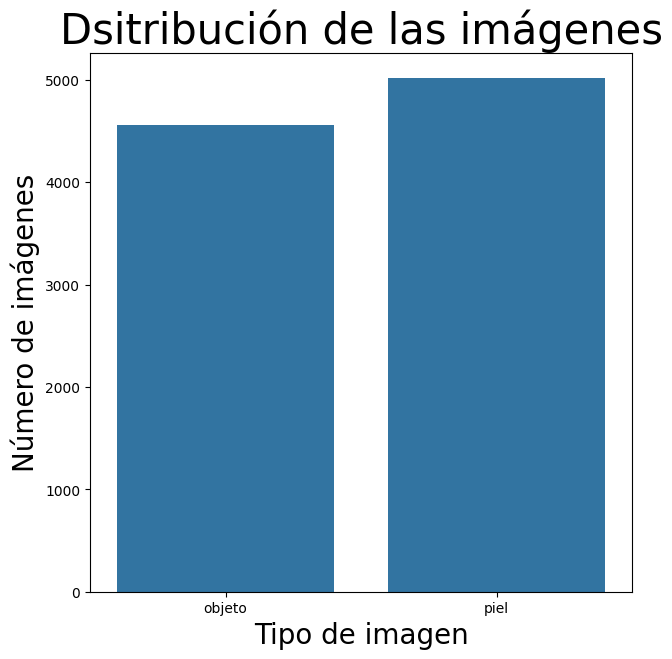

In [10]:
plt.figure(figsize=(7,7))
plt.title('Dsitribución de las imágenes',fontsize=30)
plt.ylabel('Número de imágenes',fontsize=20)
plt.xlabel('Tipo de imagen',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

### Visualización

* Función para visualizar los datos

In [11]:
# Funcion para mostrar imagénes
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

* Muestra de imágenes de objetos

Label :objeto(0)
Label :objeto(0)
Label :objeto(0)
Label :objeto(0)
Label :objeto(0)
Label :objeto(0)


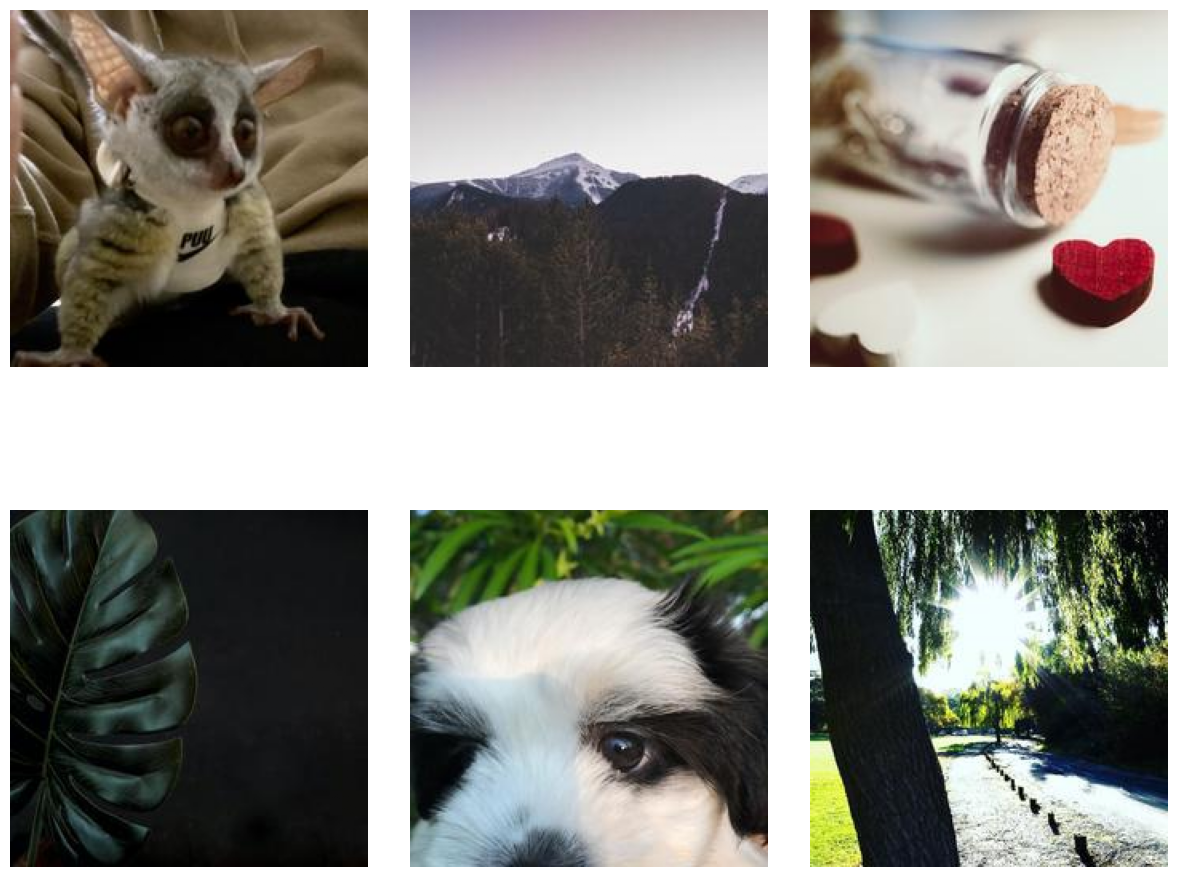

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

images_indices = [1, 65, 33, 930, 1000, 1500]

for i, ax in enumerate(axs.flatten()):
    ax.imshow(show_image(*train[images_indices[i]]))
    ax.axis('off')

plt.show()

* Muestra de imágenes de piel

Label :piel(1)
Label :piel(1)
Label :piel(1)
Label :piel(1)
Label :piel(1)
Label :piel(1)


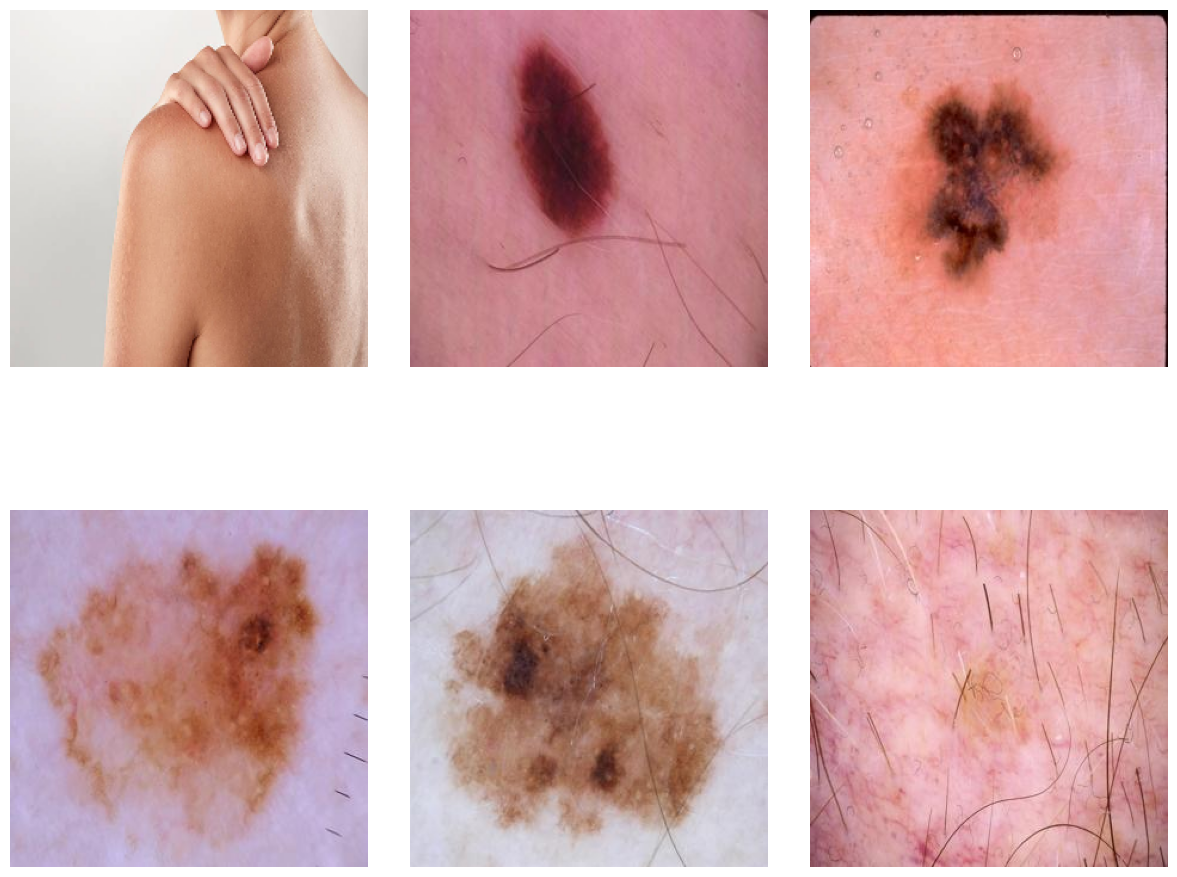

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

images_indices = [9500, 6500, 7500, 8500, 7000, 6000]

for i, ax in enumerate(axs.flat):
    ax.imshow(show_image(*train[images_indices[i]]))
    ax.axis('off')

plt.show()

## Preparación y tratamiento de datos

### Trasformación: redimensionado de imágenes

---

En este bloque de código, realizamos el proceso de transformación de nuestros datos aplicando un redimensionado de las imágenes que van a ser utilizadas en nuestros modelos posteriormente.


* Creamos la función `redimensionar_imagen`:

  * Esta función toma como entrada la ruta de una imagen y el nuevo tamaño deseado. Luego, abre la imagen, la redimensiona al nuevo tamaño especificado y la convierte en un array.

* El *tamaño* deseado para todas las imágenes se define como (150, 150).

* Redimensionamiento de las imágenes de entrenamiento: tanto para la clase "piel" como para la clase "objeto" utilizamos la función *redimensionar_imagen*.

* Nos aseguramos que todas las imágenes tengan el mismo tamaño:

  * Realizamos una comprobación con un blucle `for` para asegurarnos de que todas las imágenes tengan el tamaño correcto (150, 150, 3).

* Se concatenan los datos de ambas clases (piel y objeto) en un solo conjunto de datos.

* Creamos las etiquetas correspondientes:
  * Las imágenes de la clase "piel" se etiquetan como 0.
  * Las imágenes de la clase "objeto" se etiquetan como 1.


In [14]:
def redimensionar_imagen(ruta, nuevo_tamano):
    imagen = Image.open(ruta)
    imagen_redimensionada = imagen.resize(nuevo_tamano)
    arreglo_pixeles_redimensionado = np.array(imagen_redimensionada)
    return arreglo_pixeles_redimensionado

# Definir el nuevo tamaño deseado
nuevo_tamano = (150, 150)

# Redimensionar las imágenes de entrenamiento 'piel'
datos_train_piel_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'piel', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'piel'))]

# Redimensionar las imágenes de entrenamiento 'objeto'
datos_train_objeto_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'objeto', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'objeto'))]

# Asegurarse de que todas las imágenes tengan el mismo tamaño
datos_train_piel_redimensionados = np.array([img for img in datos_train_piel_redimensionados if img.shape == (150, 150, 3)])
datos_train_objeto_redimensionados = np.array([img for img in datos_train_objeto_redimensionados if img.shape == (150, 150, 3)])

# Concatenar los datos de ambas clases
datos_train_redimensionados = np.concatenate([datos_train_piel_redimensionados, datos_train_objeto_redimensionados], axis=0)

# Crear etiquetas correspondientes
etiquetas_train_redimensionadas = np.concatenate([np.zeros(len(datos_train_piel_redimensionados)), np.ones(len(datos_train_objeto_redimensionados))], axis=0)



* Este proceso es esencial para preparar los datos de las imágenes antes de alimentar a un modelo de ML para su entrenamiento.

* El proceso de redimensionado asegura que todas las imágenes tengan el mismo tamaño, lo que facilita el procesamiento por parte del modelo.

* La creación de etiquetas tambíen es crucial para el entrenamiento supervisado del modelo, ya que le proporciona la información necesaria sobre las clases a predecir.

### Data splitting: Conjunto de entrenamiento y test

---

Este fragmento de código se encarga de preparar los datos  y dividirlos en conjuntos de entrenamiento y test, tambíen realiza una normalización de los píxeles de las imágenes y convierte las etiquetas en formato one-hot encoding.

* División de los datos en conjuntos de entrenamiento y test:

  * Se utiliza la función `train_test_split` de *scikit-learn* para dividir los datos de imágenes (datos_train_redimensionados) y etiquetas (etiquetas_train_redimensionadas) en dos conjuntos separados: uno para entrenamiento (`X_train, y_train`) y otro para prueba (`X_test, y_test`).
  * Con el parámetro `test_size=0.2` indicamos que el 20% de los datos se utilizarán para el conjunto de prueba, mientras que el 80% se utilizará para el conjunto de entrenamiento.
  * Con el parámetro `random_state=42` aseguramos la reproducibilidad al fijar la semilla aleatoria.

* **Normalización de los píxeles:** las intensidades de los píxeles de las imágenes se normalizan dividiendo cada valor de píxel por 255.

  * Este proceso asegura que todas las características estén en una escala similar, lo que puede mejorar la convergencia del modelo durante el entrenamiento. Las imágenes se convierten a tipo de datos float32 antes de la normalización para permitir la división por un número decimal.

* Conversión de etiquetas a formato one-hot:

  * Las etiquetas (*y_train / y_test*) se convierten en formato one-hot utilizando la función `to_categorical` de Keras.
  * Esto consiste en  que cada etiqueta se representa como un vector binario donde un único valor es 1 y el resto son 0. Por ejemplo, si hay dos clases (como en este caso), la clase 0 se representará como [1, 0] y la clase 1 como [0, 1].
  * Es útil ya que proporciona una representación más adecuada de las etiquetas para el modelo de aprendizaje automático.

In [15]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_redimensionados, etiquetas_train_redimensionadas, test_size=0.2, random_state=42)

# Normalizar los píxeles dividiendo por 255
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convertir etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

* Vemos la estructura o shape de nuestros conjuntos de datos:
  * `X_train`: 7647 imagenes de 150 x 150 rgb.
  * `y_train_one_hot`: Las etiquetas del conjunto train.
  * `y_test` : solo muestra el numero de imagenes ya que el modelo en su entrenamiento no va a tener contacto con ellas y no tienen que estar en el mismo shape que X_train.
  * `y_test_one_hot`: las etiquetas de y_test para poder contrastar las predicciones del modelo y evaluar su precisión.

In [16]:
print(X_train.shape)
print(y_train_one_hot.shape)
print(y_test.shape)
print(y_test_one_hot.shape)

(7647, 150, 150, 3)
(7647, 2)
(1912,)
(1912, 2)


## Creación de los Modelos ML



### Modelo 1: Sequential

---

* Resumen:
  
```
Número de aciertos: 1875
Número de fallos: 37
Accuracy: 0.9806485355648535
```

Hemos creado, compilado y entrenado un modelo de redes neuronales convolucionales (CNN) para clasificación de imágenes usando la biblioteca Keras en TensorFlow, con varias capas convolucionales Conv2D, de normalización de lotes(*BatchNormalization*), activaciones **ReLU**, *Dropout* y agrupación máxima.


* **Crear el modelo**:
  * Se utiliza `keras.models.Sequential` para crear un modelo secuencial, que es una pila lineal de capas.
  * Agregamos varias capas convolucionales *Conv2D*, capas de normalización de lotes *BatchNormalization*, activaciones *ReLU*, capas de *Dropout*, y capas de agrupación máxima *MaxPooling2D*.
  * Comenzamos con una capa de convolución con 64 filtros de tamaño 3x3, seguida de BatchNormalization, activación *ReLU*, *Dropout* y MaxPooling2D.
  * Seguimos con otra secuencia similar de capas convolucionales y de agrupación.
  * Después de estas capas, las imágenes se aplanan en un vector unidimensional utilizando Flatten(), seguido de dos capas densas (Dense) con activación *ReLU* y *Dropout*.
  * La última capa densa tiene 2 neuronas de salida y utiliza una activación softmax para la clasificación de dos clases.

* **Compilación el modelo**:
  * Utilizamos el método `compile` para configurar el proceso de entrenamiento del modelo. Se especifica el optimizador (*Adam* con una tasa de aprendizaje de 0.0001), la función de pérdida (`categorical_crossentropy` para problemas de clasificación con más de una clase) y las métricas (`accuracy` para evaluar el rendimiento del modelo durante el entrenamiento).

* **Mostramos el resumen del modelo**:
  * Se utiliza el método summary para mostrar un resumen del modelo, que incluye información sobre la arquitectura de la red, el número de parámetros entrenables y el tamaño de cada capa.

* Entrenar el modelo:
  * Entrenamos el modelo con los datos de entrenamiento (X_train y y_train_one_hot).
  * También se especifica el conjunto de datos de validación (X_test y y_test_one_hot), el número de épocas (15) y el tamaño del lote o Batch Size(32).
  * Durante el entrenamiento, el modelo ajusta sus pesos para minimizar la pérdida en los datos de entrenamiento y evalúa su rendimiento en los datos de validación.



In [17]:
# Crear modelo
model1 = keras.models.Sequential([
    Conv2D(64, 3, input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling2D(),

    Conv2D(64, 3),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.15),
    MaxPooling2D(),

    Flatten(),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compilar el modelo
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model1.summary()

# Entrenar el modelo con los nuevos datos
history1 = model1.fit(
    X_train,
    y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    epochs=15,
    batch_size=32  # Ajustar según tus necesidades
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 148, 148, 64)      0         
                                                                 
 dropout (Dropout)           (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        3

### Evaluación de las Predicciones del Modelo 1

---

Hemos utilizado el modelo Sequential `model1` para hacer predicciones sobre el conjunto de datos de prueba (`X_test`) y luego evaluamos las predicciones comparándolas con las etiquetas reales (`y_test`).

* **Hacer predicciones con el modelo**:
  * Utilizamos el método `predict()` del modelo `model1` para hacer predicciones sobre el conjunto de datos de prueba (`X_test`). Esto genera un array de predicciones (`y_pred`) que contiene las probabilidades previstas para cada clase.

* **Obtener las clases predichas**:
  * Para cada predicción en `y_pred`, determinamos la clase predicha seleccionando el índice de la clase con la probabilidad más alta utilizando `np.argmax()`. Esto nos da un array de etiquetas predichas (`predicted_labels`).

* **Calcular el número de aciertos y fallos**:
  * Comparamos las etiquetas predichas (`predicted_labels`) con las etiquetas reales (`y_test`) para contar el número de predicciones correctas e incorrectas. Esto se hace mediante la comparación de arrays y sumando el número de coincidencias.

* **Calcular la precisión**:
  * La precisión se calcula dividiendo el número de predicciones correctas por el número total de predicciones realizadas. Esto nos da una medida de la exactitud del modelo en predecir las etiquetas correctas.

* **Imprimir resultados**:
  * Imprimimos el número de aciertos, el número de fallos y la precisión del modelo en la consola para su análisis y evaluación.

In [20]:
# EVALUACION DE MODELO 1

# Hacer predicciones con el modelo
y_pred = model1.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

60/60 [==============================] - 1s 14ms/step
Número de aciertos: 1875
Número de fallos: 37
Accuracy: 0.9806485355648535


### Modelo 2: Pre-trained InceptionV3

---

* Resumen:
```
Número de aciertos: 1904
Número de fallos: 8
Accuracy: 0.99581589958159
```

En este segundo modelo hemos utilizado el modelo pre-entrenado `InceptionV3` como base para construir un nuevo modelo de clasificación de imágenes. Este modelo ha sido pre-entrenado en el conjunto de datos de ImageNet y hemos congelado todas las capas excepto las últimas 10 para permitir la adaptación a nuestro conjunto de datos.

* **Base del modelo**:
  * Hemos utilizado `InceptionV3` como base del modelo. Al establecer `include_top=False`, hemos omitido la capa densa de salida de ImageNet y hemos especificado el tamaño de entrada de las imágenes como (150, 150, 3).
  * Hemos establecido `pooling='max'` para utilizar la capa de agrupación máxima en lugar de la capa de aplanamiento al final del modelo.

* **Capas entrenables**:
  * Hemos marcado las últimas 10 capas del modelo base como entrenables. Esto permitirá que estas capas se adapten a nuestro conjunto de datos durante el entrenamiento.

* **Aumento de datos**:
  * Hemos utilizado `ImageDataGenerator` para aumentar nuestros datos de entrenamiento con varias transformaciones, incluyendo rotación, desplazamiento horizontal y vertical, cizallamiento, zoom y volteo horizontal y vertical.
  * `datagen.fit(X_train)` se utiliza para calcular estadísticas sobre los datos de entrenamiento y configurar internamente el generador de datos para aplicar la normalización y el aumento de datos durante el entrenamiento del modelo.

* **Crear el modelo**:
  * Hemos construido nuestro modelo agregando capas adicionales encima del modelo base. Estas capas incluyen una capa densa con 512 unidades y activación ReLU, seguida de una capa de normalización de lotes y dropout. Luego, hemos añadido otra capa densa con 256 unidades, activación ReLU, normalización de lotes y dropout. La última capa densa tiene 2 neuronas de salida y utiliza una activación softmax para la clasificación de dos clases.

* **Compilar el modelo**:
  * Hemos compilado el modelo utilizando el optimizador Adam con una tasa de aprendizaje de 0.0001, la función de pérdida `categorical_crossentropy` y la métrica de `accuracy`.

* **Mostrar resumen del modelo**:
  * Hemos utilizado el método `summary` para mostrar un resumen del modelo, incluyendo información sobre la arquitectura de la red y el número de parámetros entrenables.

* **Añadir Early Stopping**:
  * Hemos añadido `EarlyStopping` como un callback para detener el entrenamiento si la precisión en el conjunto de validación deja de mejorar después de 2 épocas. Esto nos ayuda a evitar el sobreajuste y a conservar el mejor modelo.

* **Entrenar el modelo**:
  * Hemos entrenado el modelo utilizando generadores de datos tanto para los datos de entrenamiento como para los de validación. Hemos especificado un tamaño de lote de 32 y hemos entrenado durante 20 épocas, con Early Stopping como callback.


In [18]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max')

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Aumento de datos
datagen = ImageDataGenerator(
    rotation_range=40,           # Rango de rotación más amplio
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,          # Añadimos volteo vertical
    fill_mode='nearest'
)

datagen.fit(X_train)

# Crear modelo
model2 = Sequential([
    base_model,
    Dense(512, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax')
])


# Compilar el modelo
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model2.summary()

# Añadir Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# Entrenar el modelo con Early Stopping utilizando generadores de datos
history2 = model2.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    validation_data=(X_test, y_test_one_hot),
    epochs=20,
    callbacks=[early_stopping]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_96 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_97 (Bat  (None, 256)              1024      
 chNormalization)                                     

In [21]:
# EVALUACION DE MODELO 2

# Hacer predicciones con el modelo
y_pred = model2.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

60/60 [==============================] - 3s 23ms/step
Número de aciertos: 1904
Número de fallos: 8
Accuracy: 0.99581589958159


### Modelo 3: Pre-trained DenseNet121

---

* Resumen
```
Número de aciertos: 1909
Número de fallos: 3
Accuracy: 0.9984309623430963
```

Hemos utilizado el modelo pre-entrenado `DenseNet121` como base para construir un nuevo modelo de clasificación de imágenes. Este modelo ha sido pre-entrenado en el conjunto de datos de ImageNet y hemos congelado todas las capas excepto las últimas 10 para permitir la adaptación a nuestro conjunto de datos.

* **Base del modelo**:
  * Hemos utilizado `DenseNet121` como base del modelo. Al establecer `include_top=False`, hemos omitido la capa densa de salida de ImageNet y hemos especificado el tamaño de entrada de las imágenes como (150, 150, 3).
  * Hemos establecido `pooling='max'` para utilizar la capa de agrupación máxima en lugar de la capa de aplanamiento al final del modelo.

* **Capas entrenables**:
  * Hemos marcado las últimas 10 capas del modelo base como entrenables. Esto permitirá que estas capas se adapten a nuestro conjunto de datos durante el entrenamiento.

* **Aumento de datos**:
  * Hemos utilizado `ImageDataGenerator` para aumentar nuestros datos de entrenamiento con varias transformaciones, incluyendo rotación, desplazamiento horizontal y vertical, cizallamiento, zoom y volteo horizontal y vertical.

* **Crear el modelo**:
  * Hemos construido nuestro modelo agregando capas adicionales encima del modelo base. Estas capas incluyen una capa densa con 512 unidades y activación ReLU, seguida de una capa de normalización de lotes y dropout. Luego, hemos añadido otra capa densa con 256 unidades, activación ReLU, normalización de lotes y dropout. Continuamos con capas densas adicionales, cada una seguida de normalización de lotes y dropout, con la última capa densa que tiene 2 neuronas de salida y utiliza una activación softmax para la clasificación de dos clases.

* **Compilar el modelo**:
  * Hemos compilado el modelo utilizando el optimizador Adam con una tasa de aprendizaje de 0.0001, la función de pérdida `categorical_crossentropy` y la métrica de `accuracy`.

* **Mostrar resumen del modelo**:
  * Hemos utilizado el método `summary` para mostrar un resumen del modelo, incluyendo información sobre la arquitectura de la red y el número de parámetros entrenables.

* **Añadir Early Stopping**:
  * Hemos añadido Early Stopping como un callback para detener el entrenamiento si la precisión en el conjunto de validación deja de mejorar después de 2 épocas. Esto nos ayuda a evitar el sobreajuste y a conservar el mejor modelo.

* **Entrenar el modelo**:
  * Hemos entrenado el modelo utilizando generadores de datos tanto para los datos de entrenamiento como para los de validación. Hemos especificado un tamaño de lote de 32 y hemos entrenado durante 20 épocas, con Early Stopping como callback.


In [19]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max')

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Aumento de datos
datagen = ImageDataGenerator(
    rotation_range=60,           # Rango de rotación más amplio
    width_shift_range=0.35,
    height_shift_range=0.35,
    shear_range=0.35,
    zoom_range=0.35,
    horizontal_flip=True,
    vertical_flip=True,          # Agregar volteo vertical
    fill_mode='nearest'
)

datagen.fit(X_train)

# Crear modelo
model3 = Sequential([
    base_model,
    Dense(512, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.10),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.20),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 8 clases en tu caso
])


# Compilar el modelo
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model3.summary()

# Añadir Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# Entrenar el modelo con Early Stopping utilizando generadores de datos
history3 = model3.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    validation_data=(X_test, y_test_one_hot),
    epochs=20,
    callbacks=[early_stopping]
)


29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_98 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_99 (Bat  (None, 256)              

In [22]:
# EVALUACION DE MODELO 3

# Hacer predicciones con el modelo
y_pred = model3.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

60/60 [==============================] - 4s 37ms/step
Número de aciertos: 1909
Número de fallos: 3
Accuracy: 0.9984309623430963


### Resumen de resultados de los modelos

  * Una vez que hemos entrenado los 3 modelos estos han sido los resultados:

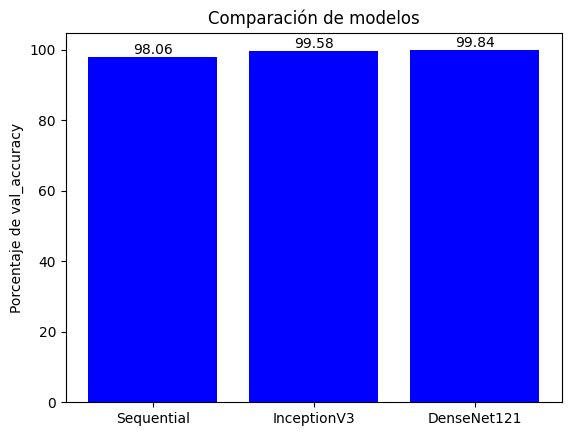

In [23]:
Sequential=0.9806485355648535
InceptionV3=0.99581589958159
DenseNet121=0.9984309623430963

# Multiplicar por 100
Sequential *= 100
InceptionV3 *= 100
DenseNet121 *= 100

# Nombres de los modelos
model_names = ['Sequential', 'InceptionV3', 'DenseNet121']

# Valores multiplicados por 100
model_values = [Sequential, InceptionV3, DenseNet121]

# Crear la gráfica de barras
fig, ax = plt.subplots()
bars = ax.bar(model_names, model_values, color='blue')
plt.ylabel('Porcentaje de val_accuracy')
plt.title('Comparación de modelos')

# Agregar los valores encima de las columnas
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


Como podemos ver el mejor resultado ha sido el `DenseNet121 con 99.84%` de val_accuracy.

### Accuracy & Loss del mejor modelo

Figure(1200x400)


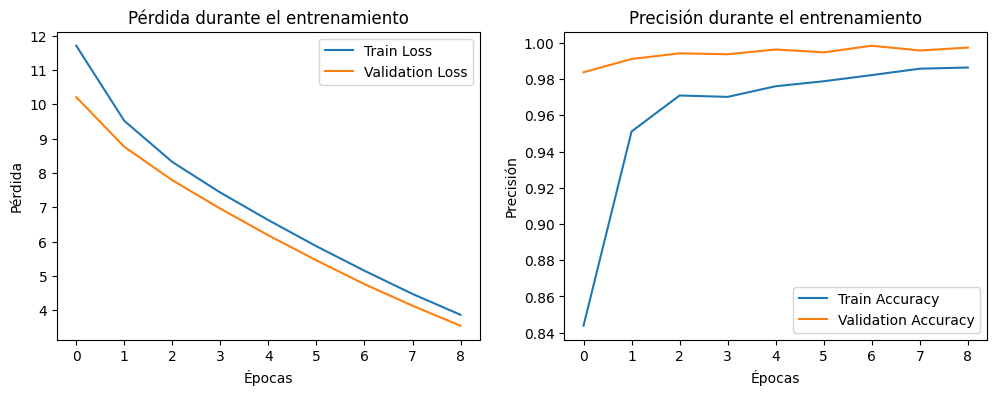

In [24]:
# Visualizar gráficos de pérdida y precisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de pérdida
ax1.plot(history3.history['loss'], label='Train Loss')
ax1.plot(history3.history['val_loss'], label='Validation Loss')
ax1.set_title('Pérdida durante el entrenamiento')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Gráfico de precisión
ax2.plot(history3.history['accuracy'], label='Train Accuracy')
ax2.plot(history3.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Precisión durante el entrenamiento')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Precisión')
ax2.legend()

print(fig)

### Conversión y Guardado del mejor Modelo en TFLite

---
Exportamos el modelo a drive en un formato .tflite ya que este formato pesa menos, puesto que a la hora de subirlo al github solo se pueden subir archivos que pesen menos de 100MB

Hemos convertido el modelo Keras `model3` en un modelo compatible con TensorFlow Lite (TFLite) utilizando `tf.lite.TFLiteConverter.from_keras_model()`. Esto convierte el modelo Keras en un formato que puede ser utilizado por dispositivos con recursos limitados, como dispositivos móviles o sistemas integrados.

* **Convertir el modelo a TFLite**:
  * Utilizamos `from_keras_model()` del objeto `TFLiteConverter` para convertir el modelo Keras `model3` en un modelo compatible con TFLite. Esto encapsula el modelo y lo prepara para ser ejecutado en dispositivos con recursos limitados.

* **Guardar el modelo TFLite en un archivo**:
  * Después de la conversión, guardamos el modelo TFLite en un archivo utilizando un objeto de archivo en modo de escritura binaria (`'wb'`). Esto nos permite almacenar el modelo en el sistema de archivos local o en la nube para su posterior uso.

* **Ruta de Guardado**:
  * El modelo TFLite se guarda en la ruta especificada `'C:/Users/admin2/Desktop/dermascan_colabs/modelos/piel_o_objeto_mejorado.tflite'`. Asegúrate de proporcionar una ruta válida y accesible para guardar el modelo.


In [25]:
from tensorflow.keras.models import load_model, save_model
# Convertir el modelo en un modelo compatible con TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Guardar el modelo TFLite en un archivo
with open('C:/Users/admin2/Desktop/dermascan_colabs/modelos/piel_o_objeto_mejorado.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\admin2\AppData\Local\Temp\tmpf4bptd68\assets


INFO:tensorflow:Assets written to: C:\Users\admin2\AppData\Local\Temp\tmpf4bptd68\assets


### Evaluación del mejor Modelo



#### Resumen del Mejor Modelo

---

* Durante la evaluación del mejor modelo, se realizaron las siguientes observaciones:

  - **Número de Aciertos**: `El modelo logró clasificar correctamente 1909 imágenes`.

  - **Número de Fallos**: `Se produjeron solamente 3 fallos en la clasificación de imágenes`.

  - **Accuracy**: `La precisión del modelo, calculada como la proporción de predicciones correctas sobre el total de predicciones, fue del 99.84 %`.


In [60]:
# Hacer predicciones con el modelo
y_pred = model3.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)

predicted_labels = np.argmax(y_pred, axis=1)

# Convertir las predicciones a etiquetas de clases (índices)
y_pred2 = y_pred.argmax(axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

# Calcular métricas
y_test_classes = y_test.flatten()

# Calcular métricas
roc_auc = roc_auc_score(y_test_classes, predicted_labels)
conf_matrix = confusion_matrix(y_test_classes, predicted_labels)
class_report = classification_report(y_test_classes, predicted_labels)

# Imprimir métricas
print(f'AUC-ROC: {roc_auc:.2f}')
print('')
print('Confusion Matrix:')
print(conf_matrix)
print('')
print('Classification Report:')
print(class_report)

60/60 [==============================] - 3s 44ms/step
Número de aciertos: 1909
Número de fallos: 3
Accuracy: 0.9984309623430963
AUC-ROC: 1.00

Confusion Matrix:
[[1013    1]
 [   2  896]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1014
         1.0       1.00      1.00      1.00       898

    accuracy                           1.00      1912
   macro avg       1.00      1.00      1.00      1912
weighted avg       1.00      1.00      1.00      1912



* Los resultados muestran que el modelo tiene un rendimiento muy alto y es capaz de realizar predicciones con una precisión casi perfecta en este conjunto de datos.

    - **Número de Aciertos**: El modelo clasificó correctamente 1909 imágenes.    
    
- **Número de Fallos**: Solo se produjeron 3 fallos en la clasificación de imágenes    .    

- **Accuracy**: La precisión del modelo, calculada como la proporción de predicciones correctas sobre el total de predicciones, fue del 99.84%. Esto indica que el modelo es altamente preciso en sus prediccion    e    s.

- **AUC-ROC**: El AUC-ROC (Area Under the Receiver Operating Characteristic Curve) mide la capacidad del modelo para distinguir entre las clases positiva y negativa. Un valor de 1.00 indica un rendimiento perfecto del modelo en esta métrica, lo que sugiere que el modelo tiene una excelente capacidad para discriminar entre las cl    a    ses.

- **Confusion Matrix**: La matriz de confusión muestra las predicciones del modelo en comparación con las clases reales. En este caso, la mayoría de las predicciones coincidieron con las clases reales, con solo 3 errores en         total.

- **Classification Report**: El informe de clasificación proporciona métricas detalladas como precisión, recall, y f1-score para cada clase, así como la precisión promedio ponderada y otras métricas agregadas. En este caso, todas las métricas son cercanas a 1.00, lo que indica un rendimiento excepcionalmente bueno del modelo en ambasto de datos.

### Muestra de predicción de imágenes

---

In [37]:
images_batch, labels_batch = validation_data

len(images_batch)

1912

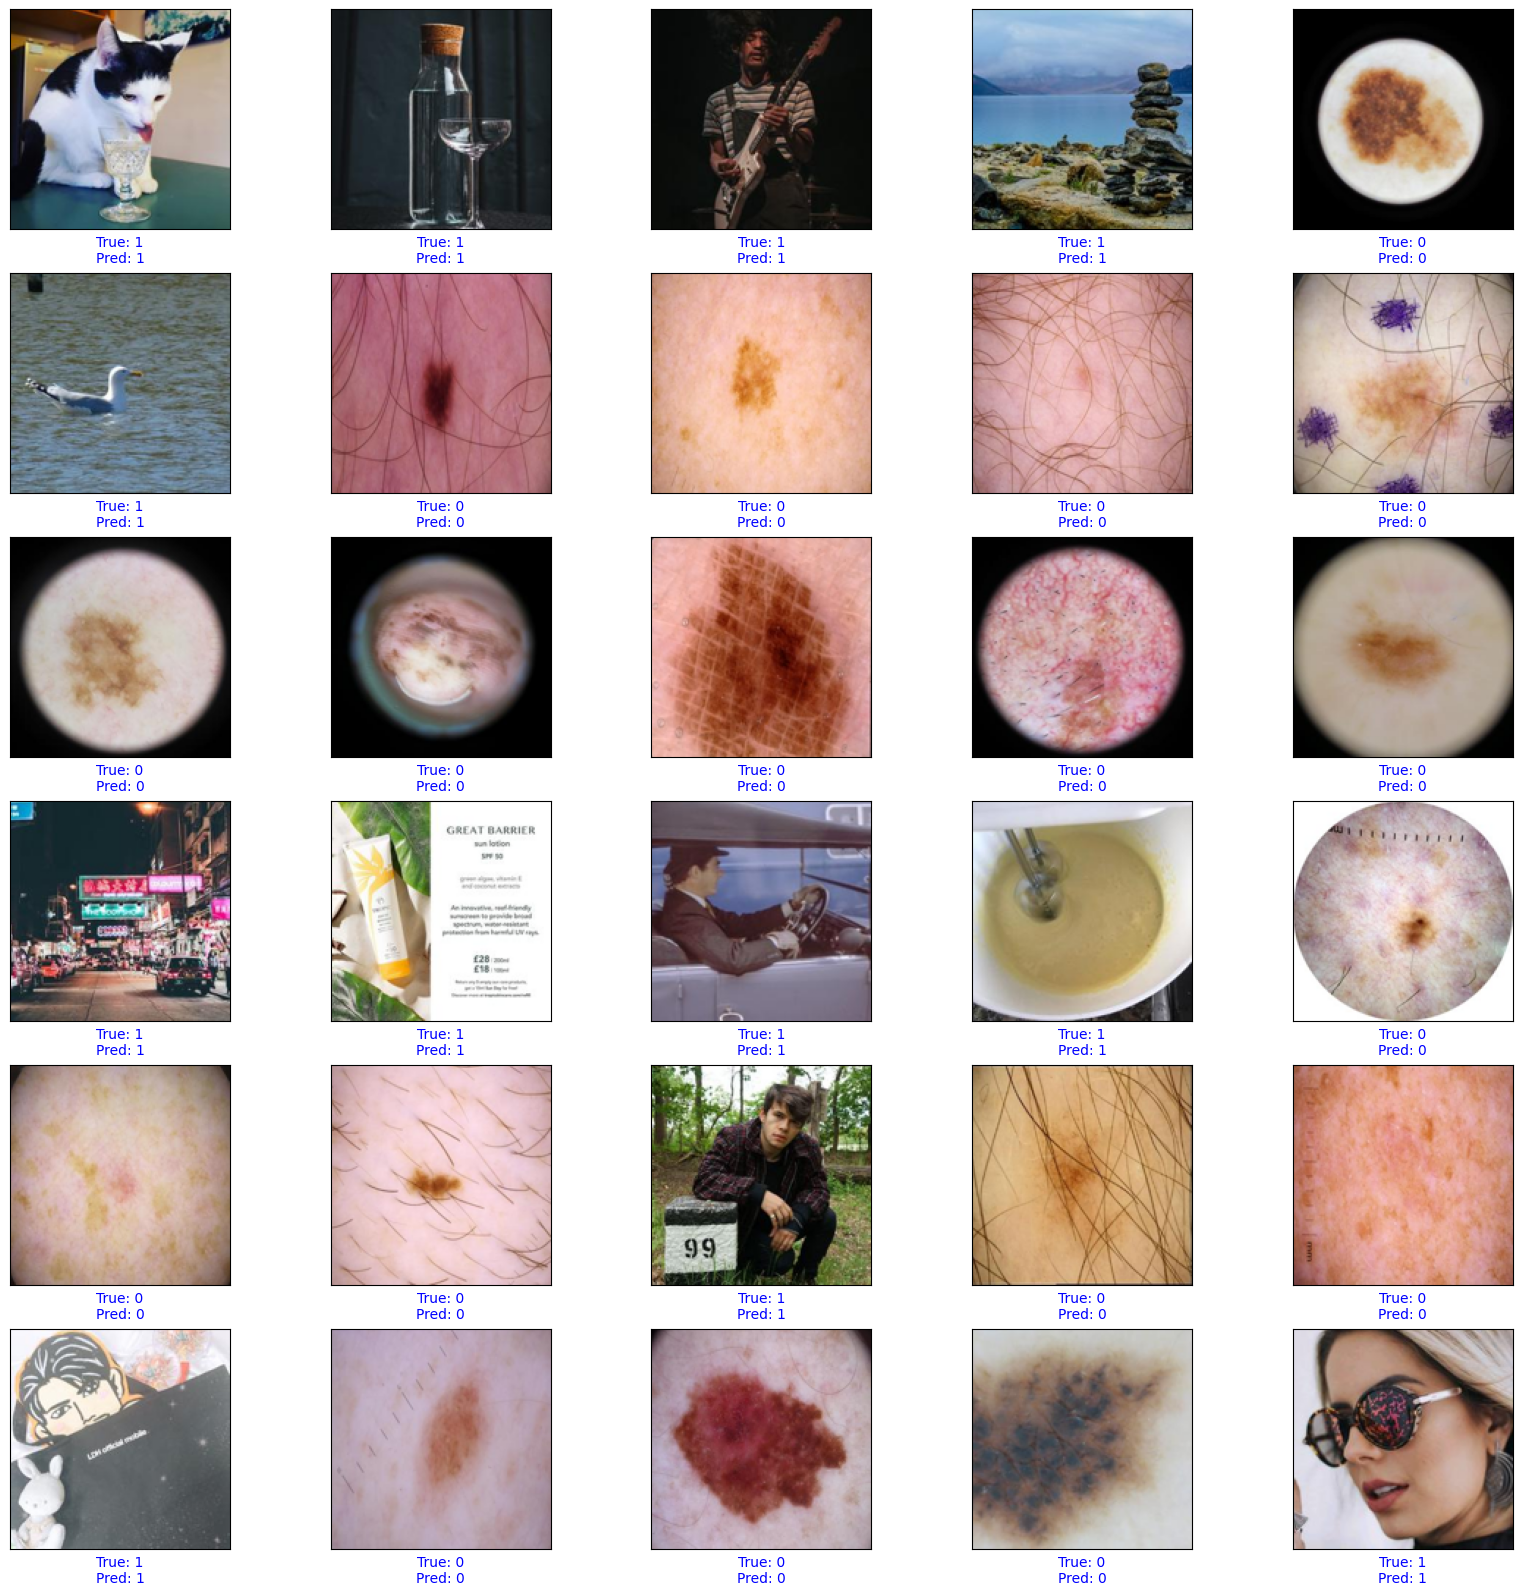

In [38]:

# Muestra los primeros 30 imágenes con la categoría real y el valor que predice el modelo
plt.figure(figsize=(20, 20))
for i in range(30):
    plt.subplot(6, 5, i + 1)  # Ajusta el número de filas y columnas según sea necesario
    cmap_image = "binary" if predicted_labels[i] == y_pred2[i] else "Oranges"
    plt.imshow(images_batch[i], cmap=cmap_image)
    plt.xticks([])
    plt.yticks([])
    c = "blue" if predicted_labels[i] == y_pred2[i] else "red"
    plt.xlabel(f"True: {predicted_labels[i]}\nPred: {y_pred2[i]}", color=c)


plt.show()

### Predicciones erróneas

--- 

In [39]:
y_diff = np.equal(predicted_labels, y_pred2)
y_diff[y_diff==False].size
indices = np.where(y_diff == False)
indices = indices[0]

60/60 [==============================] - 3s 43ms/step


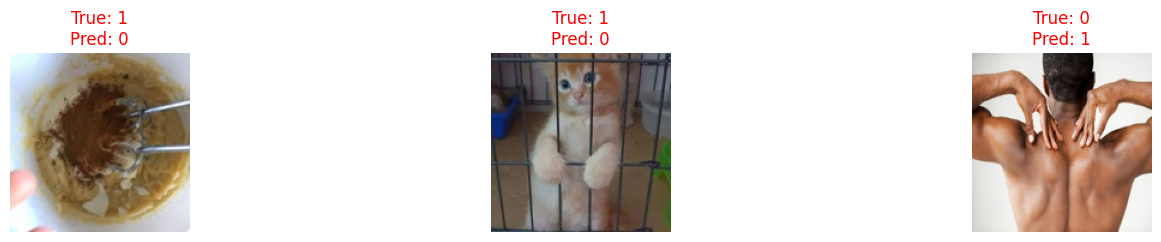

In [42]:
predictions = model3.predict(validation_data[0])  # Predice utilizando solo las imágenes de validación
y_true = validation_data[1].argmax(axis=1)  # Obtén las etiquetas verdaderas desde los datos de validación

y_pred = predictions.argmax(axis=1)
indices_mal_clasificadas = np.where(y_true != y_pred)[0]

total_imagenes = len(indices_mal_clasificadas)
filas = 8
columnas = 5

# Establecer el número máximo de imágenes a mostrar (30 o el total de imágenes mal clasificadas, el que sea menor)
max_imagenes_mostrar = min(30, total_imagenes)

plt.figure(figsize=(30, 30))
for i in range(max_imagenes_mostrar):
    imagen_mal_clasificada = validation_data[0][indices_mal_clasificadas[i]]  # Accede a las imágenes mal clasificadas desde los datos de validación

    plt.subplot(filas, columnas, i + 1)  # Ajusta el número de filas y columnas según sea necesario
    plt.imshow(imagen_mal_clasificada, cmap="Oranges")
    plt.title(f"True: {y_true[indices_mal_clasificadas[i]]}\nPred: {y_pred[indices_mal_clasificadas[i]]}", color="red")
    plt.axis('off')

plt.subplots_adjust(hspace=0.7)
plt.show()


## Prueba de predicción

### Importamos el modelo

* Extraemos nuestro modelo entrenado

In [44]:
# Ruta al archivo .tflite
ruta_archivo = 'C:/Users/admin2/Desktop/dermascan_colabs/modelos/piel_o_objeto_mejorado.tflite'

# Carga el modelo
modelo3 = tf.lite.Interpreter(model_path=ruta_archivo)
modelo3.allocate_tensors()

In [58]:
# Cargar una imagen de prueba y redimensionarla al tamaño adecuado
imagen_prueba_path = 'C:/Users/admin2/Desktop/dermascan_colabs/imagenes/objeto1.jpg'
imagen_prueba = Image.open(imagen_prueba_path)
imagen_prueba = imagen_prueba.resize((150, 150))  # Redimensionar la imagen al tamaño adecuado

# Convertir la imagen a un arreglo numpy y normalizar los valores de píxeles entre 0 y 1
imagen_array = np.array(imagen_prueba, dtype=np.float32) / 255.0

# Agregar una dimensión de lote
imagen_array = np.expand_dims(imagen_array, axis=0)

# Establecer los datos de entrada
input_details = modelo3.get_input_details()
modelo3.set_tensor(input_details[0]['index'], imagen_array)

# Realizar la predicción
modelo3.invoke()

# Obtener el resultado de la predicción
prediccion = modelo3.get_tensor(modelo3.get_output_details()[0]['index'])

# Imprimir la predicción
print("Probabilidad de clase piel:", prediccion[0, 0])
print("Probabilidad de clase objeto:", prediccion[0, 1])

# Clasificación final basada en la probabilidad más alta
clase_predicha = np.argmax(prediccion)
if clase_predicha == 0:
    print(f"La imagen es piel al {round(prediccion[0, 0] * 100, 2)}%")
else:
    print(f"La imagen es objeto al {round(prediccion[0, 1] * 100, 2)}%")

Probabilidad de clase piel: 0.0017920025
Probabilidad de clase objeto: 0.99820805
La imagen es objeto al 99.82%


## Conclusión

---

* Hemos alcanzando un 99,84% de precisión en la clasificacion de imagenes en las categorias  piel y objeto.

* Este alto porcentaje de acierto nos asegura que muestro modelo es fiable casi al 100% en el primer nivel de clasificación de nuestra aplicación que es el poder diferenciar una imagen random cualquiera de una imagen de piel humana.